# Project: Enron Data Analysis
**Author:** Nicolas Auber  
**Date:** 25 February 2021  

## Table of Contents
<ul>
<li><a href="#introduction">1. Introduction</a></li>
<li><a href="#exploration">2. Data Exploration</a></li>
<li><a href="#wrangling">3. Data Wrangling</a></li>
<li><a href="#classifier">4. Data Classifier</a></li>
</ul>

<a id='introduction'></a>
## 1. Introduction
Shortcut to chapters <a href='#introduction'>1</a>, <a href='#exploration'>2</a>, <a href='#wrangling'>3</a> and <a href='#classifier'>4</a>.  

This project is part of Airbus Data Analyst Nanodegree Progam. The purpose is to build an algorithm to identify Enron Employees who may have committed fraud based on the public Enron financial and email dataset. These Enron Employees will be identified as POI, which stands for Person Of Interest. To sum up, the purpose is to build a POI classifier.

### 1.1. Python Libraries
The libraries and functions that are used in this project are imported. The version is also displayed.

In [118]:
# Standard libraries
import sys
import time
import pickle
import numpy as np
import pandas as pd
import pprint
import matplotlib.pyplot as plt
import seaborn as sns

# Specific functions 
sys.path.append("./tools/")
from feature_format import featureFormat, targetFeatureSplit
from tester import dump_classifier_and_data, test_classifier

# Machine learning libraries
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn import tree, ensemble, neighbors
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import decomposition
from sklearn.pipeline import Pipeline

In [119]:
# Displays the version of some libraries
print("python: ", sys.version)
print("numpy: ", np.__version__)
print("pandas: ", pd.__version__)
print("seaborn: ", sns.__version__)

python:  3.7.4 (default, Aug  9 2019, 18:34:13) [MSC v.1915 64 bit (AMD64)]
numpy:  1.16.5
pandas:  0.25.1
seaborn:  0.9.0


In [120]:
t0 = time.time()

### 1.2. Input Files
The following files are available:  
- **final_project_dataset.pkl:** PKL file containing the Enron financial and email dataset  
- **enron61702insiderpay.pdf:** PDF file detailing the Enron financial data along with some explanations  
- **poi_names.txt:** TXT file listing the known POI (Person Of Interest) i.e. the Enron Employees who may have committed fraud  

Some Python scripts are provided by Udacity:  
- **poi_id.py:** Main script with some starter code available  
- **feature_format.py:** Script that extracts the features and labels from a dictionary  
- **tester.py:** Script used by Udacity to evaluate the algorithm performance and to generate the classifier, dataset and list of features  
**Note:** The functions to evaluate the algorithm performance in **tester.py** will be used also through this project. So, no specific performance evaluation function will be developed.

### 1.3. Dataset
The Enron financial and email dataset is contained in the **final_project_dataset.pkl** file. The dataset is extracted and loaded into a dictionary, where each key-value pair in the dictionary corresponds to one person. The dictionary key is the person's name, and the value is another dictionary, which contains the names of all the features and their values for that person.

In [121]:
# Loads the dictionary containing the dataset
with open("final_project_dataset.pkl", "rb") as data_file:
    data_dict = pickle.load(data_file)

In [122]:
# As already seen during Udacity Intro To Machine Learning course, there are 2 entries that are not employees.
# They are removed from the dataset.
no_employees_list = ['TOTAL', 'THE TRAVEL AGENCY IN THE PARK']
for item in no_employees_list:
    data_dict.pop(item)
    
# Enron employees
employees_list = list(data_dict.keys())
print("Number of Enron employees: ", len(employees_list))
pprint.pprint(employees_list)

Number of Enron employees:  144
['METTS MARK',
 'BAXTER JOHN C',
 'ELLIOTT STEVEN',
 'CORDES WILLIAM R',
 'HANNON KEVIN P',
 'MORDAUNT KRISTINA M',
 'MEYER ROCKFORD G',
 'MCMAHON JEFFREY',
 'HAEDICKE MARK E',
 'PIPER GREGORY F',
 'HUMPHREY GENE E',
 'NOLES JAMES L',
 'BLACHMAN JEREMY M',
 'SUNDE MARTIN',
 'GIBBS DANA R',
 'LOWRY CHARLES P',
 'COLWELL WESLEY',
 'MULLER MARK S',
 'JACKSON CHARLENE R',
 'WESTFAHL RICHARD K',
 'WALTERS GARETH W',
 'WALLS JR ROBERT H',
 'KITCHEN LOUISE',
 'CHAN RONNIE',
 'BELFER ROBERT',
 'SHANKMAN JEFFREY A',
 'WODRASKA JOHN',
 'BERGSIEKER RICHARD P',
 'URQUHART JOHN A',
 'BIBI PHILIPPE A',
 'RIEKER PAULA H',
 'WHALEY DAVID A',
 'BECK SALLY W',
 'HAUG DAVID L',
 'ECHOLS JOHN B',
 'MENDELSOHN JOHN',
 'HICKERSON GARY J',
 'CLINE KENNETH W',
 'LEWIS RICHARD',
 'HAYES ROBERT E',
 'KOPPER MICHAEL J',
 'LEFF DANIEL P',
 'LAVORATO JOHN J',
 'BERBERIAN DAVID',
 'DETMERING TIMOTHY J',
 'WAKEHAM JOHN',
 'POWERS WILLIAM',
 'GOLD JOSEPH',
 'BANNANTINE JAMES M',
 'DUNC

In [123]:
# Features for each Enron employee
features_list = list(data_dict['LAY KENNETH L'].keys())
print("Number of features: ", len(features_list))
pprint.pprint(features_list)

Number of features:  21
['salary',
 'to_messages',
 'deferral_payments',
 'total_payments',
 'loan_advances',
 'bonus',
 'email_address',
 'restricted_stock_deferred',
 'deferred_income',
 'total_stock_value',
 'expenses',
 'from_poi_to_this_person',
 'exercised_stock_options',
 'from_messages',
 'other',
 'from_this_person_to_poi',
 'poi',
 'long_term_incentive',
 'shared_receipt_with_poi',
 'restricted_stock',
 'director_fees']


The features in the dataset fall into three major types, namely financial features, email features and POI labels.  
Let's remove the **email_address** feature and re-order the remaining features as follows:  
- POI labels  
- Email features  
- Financial features

In [124]:
features_list = ['poi',
                 'from_messages', 'to_messages', 'from_this_person_to_poi', 'from_poi_to_this_person', 'shared_receipt_with_poi',
                 'salary','bonus','long_term_incentive','deferred_income','deferral_payments','loan_advances','other','expenses','director_fees','total_payments',
                 'exercised_stock_options','restricted_stock','restricted_stock_deferred','total_stock_value']
print("Number of features: ", len(features_list))

Number of features:  20


The feature **poi** is actually the label that identifies the POI (Person Of Interest).

The 5 **email features** are summarized below:     
- **from_messages:** Number of emails sent by this person  
- **to_messages:** Number of emails received by this person  
- **from_this_person_to_poi:** Number of emails sent by this person to a POI
- **from_poi_to_this_person:** Number of emails sent by a POI to this person 
- **shared_receipt_with_poi:** Number of emails received by this person with a POI in shared receipt  
**Note:** Units are generally number of emails messages; notable exception is **email_address**, which is a text string. But this feature has been removed from **features_list** above.

The 14 **financial features** are presented in input PDF file. See a quick summary below:      
- **salary:** (1) Items such as base salary, executive cash allowances, and benefits payments  
- **bonus:** (2) Annual cash incentives paid based upon company performance  
- **long_term_incentive:** (3) Long-term incentive cash payments  
- **deferred_income:** (4) Voluntary executive deferrals of salary, annual cash incentives, and long-term cash incentives  
- **deferral_payments:** (5) Distributions from a deferred compensation arrangement  
- **loan_advances:** (6) Total amount of loan advances  
- **other:** (7) Items such as payments for severence, consulting services, relocation costs...
- **expenses:** (8) Reimbursements of business expenses
- **director_fees:** (9) Cash payments and/or value of stock grants made in lieu of cash payments to non-employee directors  
- **total_payments:** Total amount of above "payment" items  
- **exercised_stock_options:** (10) Amounts from exercised stock options  
- **restricted_stock:** (11) The gross fair market value of shares and accrued dividends
- **restricted_stock_deferred:** (12) Value of restricted stock
- **total_stock_value:**  Total amount of above "stock" items  
**Note:** All units are in US dollars.

<a id='exploration'></a>
## 2. Data Exploration
Shortcut to chapters <a href='#introduction'>1</a>, <a href='#exploration'>2</a>, <a href='#wrangling'>3</a> and <a href='#classifier'>4</a>.  

The objective in this chapter is to explore the dataset in order to know the dataset better and maybe identify any problems in the data set. We will explore the dataset using a pandas dataframe.

In [125]:
data = featureFormat(data_dict, features_list, remove_NaN=False, remove_all_zeroes=False, remove_any_zeroes=False, sort_keys = False)
df = pd.DataFrame(data, index=employees_list, columns=features_list)

### 2.1. Overview
Overall information is given on the dataframe below.

In [126]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 144 entries, METTS MARK to GLISAN JR BEN F
Data columns (total 20 columns):
poi                          144 non-null float64
from_messages                86 non-null float64
to_messages                  86 non-null float64
from_this_person_to_poi      86 non-null float64
from_poi_to_this_person      86 non-null float64
shared_receipt_with_poi      86 non-null float64
salary                       94 non-null float64
bonus                        81 non-null float64
long_term_incentive          65 non-null float64
deferred_income              48 non-null float64
deferral_payments            38 non-null float64
loan_advances                3 non-null float64
other                        91 non-null float64
expenses                     94 non-null float64
director_fees                16 non-null float64
total_payments               123 non-null float64
exercised_stock_options      101 non-null float64
restricted_stock             109 non-null fl

In [127]:
print(df.head())

                  poi  from_messages  to_messages  from_this_person_to_poi  \
METTS MARK        0.0           29.0        807.0                      1.0   
BAXTER JOHN C     0.0            NaN          NaN                      NaN   
ELLIOTT STEVEN    0.0            NaN          NaN                      NaN   
CORDES WILLIAM R  0.0           12.0        764.0                      0.0   
HANNON KEVIN P    1.0           32.0       1045.0                     21.0   

                  from_poi_to_this_person  shared_receipt_with_poi    salary  \
METTS MARK                           38.0                    702.0  365788.0   
BAXTER JOHN C                         NaN                      NaN  267102.0   
ELLIOTT STEVEN                        NaN                      NaN  170941.0   
CORDES WILLIAM R                     10.0                     58.0       NaN   
HANNON KEVIN P                       32.0                   1035.0  243293.0   

                      bonus  long_term_incentive  

In [128]:
print("Total: ", df['poi'].count())
print("Number of POI: ", df[df['poi']==True]['poi'].count())
print("Number of non POI: ", df[df['poi']==False]['poi'].count())
print("###")
#df = df[df['salary'].notnull()]
#df = df[df['bonus'].notnull()]
df1 = df[df['from_messages'].notnull()]
print(df1.count())
print("###")
print("Total: ", df1['poi'].count())
print("Number of POI: ", df1[df1['poi']==True]['poi'].count())
print("Number of non POI: ", df1[df1['poi']==False]['poi'].count())

Total:  144
Number of POI:  18
Number of non POI:  126
###
poi                          86
from_messages                86
to_messages                  86
from_this_person_to_poi      86
from_poi_to_this_person      86
shared_receipt_with_poi      86
salary                       67
bonus                        61
long_term_incentive          48
deferred_income              26
deferral_payments            22
loan_advances                 3
other                        63
expenses                     60
director_fees                 2
total_payments               75
exercised_stock_options      67
restricted_stock             76
restricted_stock_deferred     7
total_stock_value            80
dtype: int64
###
Total:  86
Number of POI:  14
Number of non POI:  72


In [129]:
# Checks if some employees have only NaN values
df[df.isnull().sum(axis=1)==len(features_list)-1].index[:]

Index(['LOCKHART EUGENE E'], dtype='object')

In [130]:
print(data_dict['LOCKHART EUGENE E'])

{'salary': 'NaN', 'to_messages': 'NaN', 'deferral_payments': 'NaN', 'total_payments': 'NaN', 'loan_advances': 'NaN', 'bonus': 'NaN', 'email_address': 'NaN', 'restricted_stock_deferred': 'NaN', 'deferred_income': 'NaN', 'total_stock_value': 'NaN', 'expenses': 'NaN', 'from_poi_to_this_person': 'NaN', 'exercised_stock_options': 'NaN', 'from_messages': 'NaN', 'other': 'NaN', 'from_this_person_to_poi': 'NaN', 'poi': False, 'long_term_incentive': 'NaN', 'shared_receipt_with_poi': 'NaN', 'restricted_stock': 'NaN', 'director_fees': 'NaN'}


**Summary:**  
- There are many NaN values.
- By removing the NaN values (i.e. 58 data points) for the feature **from_messages**, we still have a correct number of values for the financial data. Even if not chosen, a way forward to build the classifier could be the deletion of all the entries with no email data.

### 2.2. Distribution Plots
Let's plot 2 distributions for one financial feature **salary** and one email feature **to_messages**.

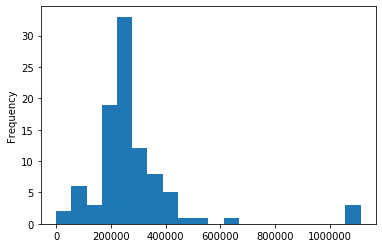

In [131]:
df['salary'].plot.hist(bins=20)
plt.show()

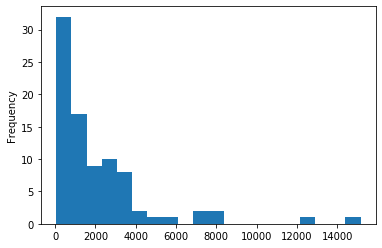

In [132]:
df['to_messages'].plot.hist(bins=20)
plt.show()

**Summary:** The above distributions are positively skewed distributions. 

### 2.3. Scatter Plots 

In [133]:
# Displays a scatter plot for 2 features distinguishing the POI and non POI 
def plotGraph(feature1, feature2):
    x_poi = df[df['poi']==True][feature1].tolist()
    x_npoi = df[df['poi']==False][feature1].tolist()
    y_poi = df[df['poi']==True][feature2].tolist()
    y_npoi = df[df['poi']==False][feature2].tolist()
    plt.scatter(x_poi, y_poi, color='r', label = 'poi') 
    plt.scatter(x_npoi, y_npoi, color='b', label = 'non poi') 
    plt.xlabel(feature1)
    plt.ylabel(feature2)
    plt.legend()
    plt.show()

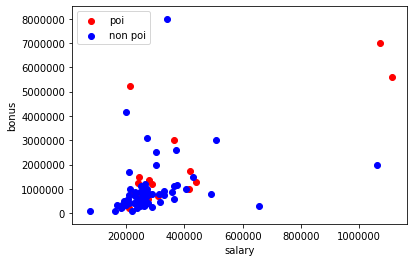

                    poi     salary      bonus
LAVORATO JOHN J     0.0   339288.0  8000000.0
WHALLEY LAWRENCE G  0.0   510364.0  3000000.0
LAY KENNETH L       1.0  1072321.0  7000000.0
BELDEN TIMOTHY N    1.0   213999.0  5249999.0
SKILLING JEFFREY K  1.0  1111258.0  5600000.0
ALLEN PHILLIP K     0.0   201955.0  4175000.0
PICKERING MARK R    0.0   655037.0   300000.0
FREVERT MARK A      0.0  1060932.0  2000000.0


In [134]:
# Scatter plot 'salary' vs 'bonus'. Prints remarkable values. 
plotGraph('salary', 'bonus')
print(df.loc[(df['salary'] > 500000) | (df['bonus'] > 4000000),['poi','salary','bonus']])

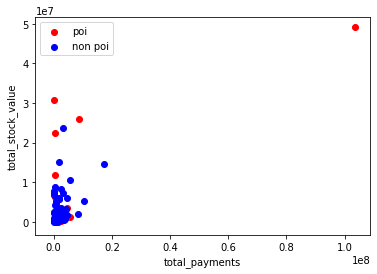

                    poi  total_payments  total_stock_value
BAXTER JOHN C       0.0       5634343.0         10623258.0
LAY KENNETH L       1.0     103559793.0         49110078.0
RICE KENNETH D      1.0        505050.0         22542539.0
SKILLING JEFFREY K  1.0       8682716.0         26093672.0
WHITE JR THOMAS E   0.0       1934359.0         15144123.0
YEAGER F SCOTT      1.0        360300.0         11884758.0
HIRKO JOSEPH        1.0         91093.0         30766064.0
FREVERT MARK A      0.0      17252530.0         14622185.0
PAI LOU L           0.0       3123383.0         23817930.0


In [135]:
# Scatter plot 'total_payments' vs 'total_stock_value'. Prints remarkable values.
plotGraph('total_payments', 'total_stock_value')
print(df.loc[df['total_stock_value'] > 10000000,['poi','total_payments','total_stock_value']])

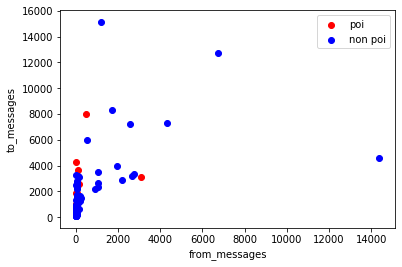

                     poi  from_messages  to_messages
KITCHEN LOUISE       0.0         1728.0       8305.0
BECK SALLY W         0.0         4343.0       7315.0
LAVORATO JOHN J      0.0         2585.0       7259.0
SHAPIRO RICHARD S    0.0         1215.0      15149.0
WHALLEY LAWRENCE G   0.0          556.0       6019.0
BELDEN TIMOTHY N     1.0          484.0       7991.0
KAMINSKI WINCENTY J  0.0        14368.0       4607.0
KEAN STEVEN J        0.0         6759.0      12754.0


In [136]:
# Scatter plot 'from_messages' vs 'to_messages'. Prints remarkable values.
plotGraph('from_messages', 'to_messages')
print(df.loc[(df['to_messages'] > 5000) | (df['from_messages'] > 5000),['poi','from_messages','to_messages']])

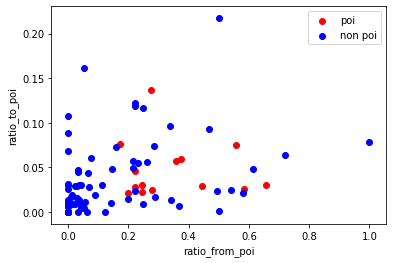

                      poi  ratio_from_poi  ratio_to_poi
HUMPHREY GENE E       0.0        1.000000      0.078125
DEFFNER JOSEPH M      0.0        0.054054      0.161064
DONAHUE JR JEFFREY M  0.0        0.500000      0.217341


In [137]:
# Creates new email features focusing on ratios.
df['ratio_from_poi']= df['from_this_person_to_poi'] / df['from_messages']
df['ratio_to_poi']= df['from_poi_to_this_person'] / df['to_messages']
df['ratio_shared_poi']= df['shared_receipt_with_poi'] / df['to_messages']

# Scatter plot 'ratio_from_poi' vs 'ratio_to_poi'. Prints remarkable values.
plotGraph('ratio_from_poi', 'ratio_to_poi')
print(df.loc[(df['ratio_from_poi'] > 0.8) | (df['ratio_to_poi'] > 0.15),['poi','ratio_from_poi','ratio_to_poi']])

**Summary:** Please find a few comments below.   
- **salary/bonus** plot: No outliers
- **total_payments/total_stock_value** plot: Enron founder Kenneth Lay is an outlier. Indeed, as a very specific POI, this data point will probably modify the POI classifier. This data point will be removed.
- **from_messages/to_messages** plot: Wincenty Kaminski will be considered as an outlier. Indeed, the number of messages sent by this person are very high and this is not a POI. I had some doubts about that outlier but this decision was taken based on the POI classifier performance with and without this data point.
- **ratio_from_poi/ratio_to_poi** plot: As seen during Udacity training, the ratio values instead of absolute values might be interesting for the classifier. It is confirmed by this plot. All values with a ratio_from_poi less than 0.2 are not POI. Maybe a decision tree classifier would be a good solution for the algorithm.

<a id='wrangling'></a>
## 3. Data Wrangling
Shortcut to chapters <a href='#introduction'>1</a>, <a href='#exploration'>2</a>, <a href='#wrangling'>3</a> and <a href='#classifier'>4</a>.  

The objective in this chapter is to wrangle the data. The following checks will be done.
- **Missing values**
- **Consistent values** on POI label
- **Outliers**

### 3.1. Missing Values
As observed in chapter <a href='#exploration'>§2</a>, the number of data points is small (144 employees) and the number of missing values (NaN values) is large for some features. The decision is taken to discard the features with a large number of missing values. An arbitrary value of 81 (value for **bonus** feature) is considered.  

In [138]:
for col in df.columns:
    if df[col].count() < 81:
        features_list.remove(col)
print("Number of features: ", len(features_list))
pprint.pprint(features_list)

Number of features:  14
['poi',
 'from_messages',
 'to_messages',
 'from_this_person_to_poi',
 'from_poi_to_this_person',
 'shared_receipt_with_poi',
 'salary',
 'bonus',
 'other',
 'expenses',
 'total_payments',
 'exercised_stock_options',
 'restricted_stock',
 'total_stock_value']


**Note:** The remaining NaN values will be imported as null values. 

### 3.2. Consistent Values on POI label
The dataset provides a list of 18 POI and the input TXT file provides a list of POI. Let's check if the 2 lists of POI are consistent.

In [139]:
# Generates a list of POI (FIRST NAME LAST NAME) from poi_names.txt file
poi_list1 = []
with open('poi_names.txt', 'r') as f:
    for line in f:
        if line[0] == '(':
            line = line.replace(',','')
            name = line.split()
            poi_list1.append(name[1].upper()+" "+name[2].upper())
print("Number of POI: ", len(poi_list1))
print(poi_list1)

Number of POI:  35
['LAY KENNETH', 'SKILLING JEFFREY', 'HOWARD KEVIN', 'KRAUTZ MICHAEL', 'YEAGER SCOTT', 'HIRKO JOSEPH', 'SHELBY REX', 'BERMINGHAM DAVID', 'DARBY GILES', 'MULGREW GARY', 'BAYLEY DANIEL', 'BROWN JAMES', 'FURST ROBERT', 'FUHS WILLIAM', 'CAUSEY RICHARD', 'CALGER CHRISTOPHER', 'DESPAIN TIMOTHY', 'HANNON KEVIN', 'KOENIG MARK', 'FORNEY JOHN', 'RICE KENNETH', 'RIEKER PAULA', 'FASTOW LEA', 'FASTOW ANDREW', 'DELAINEY DAVID', 'GLISAN BEN', 'RICHTER JEFFREY', 'LAWYER LARRY', 'BELDEN TIMOTHY', 'KOPPER MICHAEL', 'DUNCAN DAVID', 'BOWEN RAYMOND', 'COLWELL WESLEY', 'BOYLE DAN', 'LOEHR CHRISTOPHER']


In [140]:
# Updates the format of the fullname coming from the Enron dataset
def updateName(fullname):
    list = fullname.split()
    if len(list[1])==1: #Example 'YEAGER F SCOTT'
        name = list[0] + " " + list[2]
    elif list[1]=="JR." or list[1]=="JR": #Example: 'WHITE JR THOMAS E'
        name = list[0] + " " + list[2]
    else: #Example: 'KEAN STEVEN J' or 'FOWLER PEGGY'
        name = list[0] + " " + list[1]
    return name

# Generates a list of POI and a list of non POI from the Enron dataset
poi_list2 = []
npoi_list2 = []
for employee in employees_list:
    if data_dict[employee]['poi'] == True:
        poi_list2.append(updateName(employee))
    else:
        npoi_list2.append(updateName(employee))

print("Number of non POI: ", len(npoi_list2))
print("Number of POI: ", len(poi_list2))
print(poi_list2)

Number of non POI:  126
Number of POI:  18
['HANNON KEVIN', 'COLWELL WESLEY', 'RIEKER PAULA', 'KOPPER MICHAEL', 'SHELBY REX', 'DELAINEY DAVID', 'LAY KENNETH', 'BOWEN RAYMOND', 'BELDEN TIMOTHY', 'FASTOW ANDREW', 'CALGER CHRISTOPHER', 'RICE KENNETH', 'SKILLING JEFFREY', 'YEAGER SCOTT', 'HIRKO JOSEPH', 'KOENIG MARK', 'CAUSEY RICHARD', 'GLISAN BEN']


In [141]:
# Checks if the employees labeled as POI in Enron dataset are also listed in poi_names.txt
for POI in poi_list2:
    if POI not in poi_list1:
        print(POI, ", which is a POI, is not listed in poi_names.txt file.")

# Checks if the employees labeled as non POI in Enron dataset are not listed in poi_names.txt
for NPOI in npoi_list2:
    if NPOI in poi_list1:
        print(NPOI, ", which is not a POI, is listed in poi_names.txt file.")

### 3.3. Outliers
As observed in chapter <a href='#exploration'>§2</a>, 3 data points have been defined as outliers and are removed from the dataset:

- **KENNETH LAY** is considered as outlier regarding the financial data
- **WINCENTY KAMINSKI** is considered as outlier regarding the email data
- **EUGENE LOCKHART** is considered as outlier regarding the lack of data

In [142]:
# Removes the outliers from the Enron dataset
outliers_list = ['LAY KENNETH L', 'KAMINSKI WINCENTY J','LOCKHART EUGENE E']
for item in outliers_list:
    data_dict.pop(item)
    
# Enron employees
employees_list = list(data_dict.keys())
print("Number of employees: ", len(employees_list))

Number of employees:  141


### 3.4. Summary
Some data wrangling has been done in this chapter. Other decisions could have been made on outliers or on the NaN values (mean values instead of null values); other checks could have been done as well on financial data. One key point in this data wrangling was to limit the number of features as the number of data points is quite small to prevent from overfitting. Let's see if the POI classifier works well.

In [143]:
# Creates the dataset
my_dataset = data_dict

<a id='classifier'></a>
## 4. Data Classifier
Shortcut to chapters <a href='#introduction'>1</a>, <a href='#exploration'>2</a>, <a href='#wrangling'>3</a> and <a href='#classifier'>4</a>.  

The objective of this chapter is to build a POI classifier based on Enron dataset. It will be done in several steps:  
- Create new features
- Select the features
- Try a variety of classifiers and select the right classifier
- Tune the selected classifier
- Run the optimized classifier

### 4.1. New Features
As observed in chapter <a href='#exploration'>§2</a>, the email features would be interested in terms of ratio. New email features are created below.

In [144]:
# Calculates the ratio between 2 values. NaN for any of the 2 values will result in null values.
def calcRatio(poi_messages, all_messages):
    ratio = 0.
    if poi_messages == "NaN" or all_messages == "NaN":
        ratio = 0.
    else:
        ratio = float(poi_messages) / float(all_messages)
    return ratio

# Generates new features in the dataset
for name in data_dict:
    data_dict[name]['ratio_to_poi'] = calcRatio(data_dict[name]['from_this_person_to_poi'],data_dict[name]['from_messages'])
    data_dict[name]['ratio_from_poi'] = calcRatio(data_dict[name]['from_poi_to_this_person'],data_dict[name]['to_messages'])
    data_dict[name]['ratio_shared_poi'] = calcRatio(data_dict[name]['shared_receipt_with_poi'],data_dict[name]['to_messages'])

### 4.2. Feature Selection
Two types of feature selection is done:  
- **Manual feature selection** based on the importance of features using a Decision Tree classifier
- **Univariate feature selection** using a pipeline selectKBest and Decision Tree classifier

In [145]:
# Creates a list of email features
features_email_list = ['poi',
                       'from_this_person_to_poi','from_poi_to_this_person','shared_receipt_with_poi','from_messages','to_messages',
                       'ratio_from_poi','ratio_to_poi','ratio_shared_poi']

# Evaluates the performance of the classifier
clf = tree.DecisionTreeClassifier()
test_classifier(clf, my_dataset, features_email_list)

# Displays the importance of features
print("Features importance for email features:")
for importance, feature in sorted(zip(clf.feature_importances_, features_email_list[1:]),reverse=True):
    print ('{}: {:.3}'.format(feature, importance))

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')
	Accuracy: 0.835	Precision: 0.316	Recall: 0.419	F1: 0.361	F2: 0.394
	Total predictions: 9000	True positives:  419	False positives:  905	False negatives:  581	True negatives: 7095

Features importance for email features:
ratio_to_poi: 0.317
shared_receipt_with_poi: 0.281
ratio_from_poi: 0.126
from_poi_to_this_person: 0.112
to_messages: 0.0957
from_this_person_to_poi: 0.068
ratio_shared_poi: 0.0
from_messages: 0.0


In [146]:
# Extracts the labels and features used by the POI classifier
data = featureFormat(data_dict, features_list,remove_all_zeroes=True)
labels, features = targetFeatureSplit(data)
features_train, features_test, labels_train, labels_test = train_test_split(features, labels, test_size=0.3, random_state=42)

# Creates a pipeline of two steps.
pipe = Pipeline([('sel', SelectKBest()),
                 ('clf', tree.DecisionTreeClassifier())])

### Parameters
k = [1,2,3,4,5]
max_depth = [2,4,6]
min_samples_split = [2,10,20]

# Creates Parameter Space
parameters = [{'sel__k':k},
              {'clf__max_depth':max_depth,
               'clf__min_samples_split':min_samples_split}]

# Conducts Parameter Optmization With Pipeline
# Creating a grid search object
clf = GridSearchCV(pipe, parameters, scoring='recall', cv=5)

# Fits the grid search
clf.fit(features_train, labels_train)

# Prints the Best Parameters
print('Best score:', clf.best_score_)
print('Best estimator:', clf.best_estimator_)

Best score: 0.4982993197278911
Best estimator: Pipeline(memory=None,
         steps=[('sel',
                 SelectKBest(k=10,
                             score_func=<function f_classif at 0x000001EB1A1A7D38>)),
                ('clf',
                 DecisionTreeClassifier(class_weight=None, criterion='gini',
                                        max_depth=4, max_features=None,
                                        max_leaf_nodes=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=1, min_samples_split=2,
                                        min_weight_fraction_leaf=0.0,
                                        presort=False, random_state=None,
                                        splitter='best'))],
         verbose=False)


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


**Summary:**  
Following the study performed above, it is decided to select manually the email features as follows.

In [147]:
# Adds the newly selected email features to the list of features
append_feature_list = ['ratio_from_poi','ratio_to_poi']
for feature in append_feature_list:
    features_list.append(feature)

In [148]:
# Removes the non selected email features from the list of features
remove_feature_list = ['from_this_person_to_poi','from_poi_to_this_person','from_messages']
for feature in remove_feature_list:
    features_list.remove(feature)

### 4.3. Multiple Classifiers
A variety of standard classifiers will be tested. Some rationale is provided for the selection.  

- **Naive Bayes:** Simple to use, very efficient, independant features  
- **Decision Tree:** Easy to use, good interpretability, email features plot above  
- **AdaBoost** and **RandomForest:** Ensemble methods using decision trees. Maybe with better performance compared to Decision Tree classifier  
- **KNN:** Popular classifier  
- **SVC:** Popular classifier

In [149]:
# List of classifiers
classifiers = [GaussianNB(),
               tree.DecisionTreeClassifier(),
               ensemble.AdaBoostClassifier(),
               ensemble.RandomForestClassifier(),
               neighbors.KNeighborsClassifier(),
               SVC(gamma='auto')]

# Evaluates the performance for each classifier
for classifier in classifiers:
    clf = classifier
    test_classifier(clf, my_dataset, features_list)

GaussianNB(priors=None, var_smoothing=1e-09)
	Accuracy: 0.826	Precision: 0.324	Recall: 0.283	F1: 0.303	F2: 0.291
	Total predictions: 15000	True positives:  567	False positives: 1181	False negatives: 1433	True negatives: 11819

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')
	Accuracy: 0.831	Precision: 0.366	Recall: 0.361	F1: 0.364	F2: 0.362
	Total predictions: 15000	True positives:  722	False positives: 1250	False negatives: 1278	True negatives: 11750

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=50, random_state=None)
	Accuracy: 0.833	Precision: 0.329	Recall: 0.247	F1:

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
	Accuracy: 0.858	Precision: 0.390	Recall: 0.117	F1: 0.179	F2: 0.136
	Total predictions: 15000	True positives:  233	False positives:  364	False negatives: 1767	True negatives: 12636

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')
	Accuracy: 0.886	Precision: 0.747	Recall: 0.220	F1: 0.340	F2: 0.256
	Total predictions: 15000	True positives:  440	False positives:  149	Fals

**Summary:**   
- **Naive Bayes:** Very good overall performance.  
- **Decision Tree:** Very good overall performance.  
- **AdaBoost:** Very good overall performance  
- **RandomForest:** Good performance except for the recall  
- **KNN:** Bad performance. The reason could be that no feature scaling was performed. Feature scaling and principal component analysis was tested with KNN algorithm but is not presented in this project (the code is available in **poi_id.py**)   
- **SVM:** Bad performance as the precision or recall are undefined. As seen during Udacity course, this algorithm works well when there is a clear margin of separation and no overlap of the classes. As observed during the data exploration, POI and non POI are overlapping for most features. So, this is not a suprise.  

**Conclusion:** **Naive Bayes**, **Decision Tree** and **AdaBoost** classifiers have about the same performance. The **Decision Tree** classifier will be selected to build the POI classifier.

### 4.4. Classifier Best Parameters
The selected classifier **Decision Tree** will be tuned in order to get the best parameters. 3 parameters are chosen: **criterion**, **max_depth** and **min_samples_split**.  

During this analysis, 2 parameters might impact this tuning:  
- **test_size** when the train/test data are split due to the low number of data points. A standard value of 0.3 is chosen.
- **scoring** used in GridSearchCV. Indeed, the performance evaluation through GridSearchCV will be not the same performance evaluation performed through **tester.py**. Let's assume this is not a problem. As the objective of this project is to get a minimum of 0.3 for both precision and recall, this parameter is set to 'recall' since the recall is very closed to 0.3 whereas the precision is higher.

In [150]:
data = featureFormat(data_dict, features_list,remove_all_zeroes=True)
labels, features = targetFeatureSplit(data)

# Splits the train/test data for the features and labels
features_train, features_test, labels_train, labels_test = train_test_split(features, labels, test_size=0.3, random_state=42)

### Parameters for GridSearchCV
criterion = ['gini', 'entropy']
max_depth = [2,4,6,8,10,15,20,50]
min_samples_split = [2,10,20,30,40]

parameters = {'criterion':criterion,
              'max_depth':max_depth,
              'min_samples_split':min_samples_split}

# Runs GridSearchCV
clf = GridSearchCV(tree.DecisionTreeClassifier(), parameters, scoring='recall', cv=5)
clf.fit(features_train, labels_train)

# Viewing of the Best Parameters
print('Best criterion:', clf.best_estimator_.get_params()['criterion'])
print('Best max_depth:', clf.best_estimator_.get_params()['max_depth'])
print('Best min_samples_split:', clf.best_estimator_.get_params()['min_samples_split'])

Best criterion: entropy
Best max_depth: 10
Best min_samples_split: 2


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


### 4.5. Final Classifier
The POI identifier will be the **DecisionTree** classifier optimized with the above best parameters.

In [151]:
clf = tree.DecisionTreeClassifier(criterion='entropy',max_depth=6,min_samples_split=2)
test_classifier(clf, my_dataset, features_list)

# Prints the feature importance
print("Features importance:")
for importance, feature in sorted(zip(clf.feature_importances_, features_list[1:]),reverse=True)[:5]:
    print ('{}: importance = {:.3}'.format(feature, importance))

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=6,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')
	Accuracy: 0.841	Precision: 0.406	Recall: 0.414	F1: 0.410	F2: 0.412
	Total predictions: 15000	True positives:  828	False positives: 1211	False negatives: 1172	True negatives: 11789

Features importance:
other: importance = 0.278
ratio_to_poi: importance = 0.233
expenses: importance = 0.23
total_stock_value: importance = 0.108
shared_receipt_with_poi: importance = 0.0915


In [155]:
# Summarizes the metrics before and after optimization (manual copy/paste)
performance_df = pd.DataFrame(
    data=[[0.831, 0.366, 0.361, 0.364, 0.362],
          [0.841, 0.406, 0.414, 0.410, 0.412]],
    index=['DecisionTree Before Optimization', 'DecisionTree After Optimization'],
    columns=['Accuracy', 'Precision', 'Recall', 'F1', 'F2'])
print(performance_df)

                                  Accuracy  Precision  Recall     F1     F2
DecisionTree Before Optimization     0.831      0.366   0.361  0.364  0.362
DecisionTree After Optimization      0.841      0.406   0.414  0.410  0.412


**Summary:**   
All metrics have been improved after the optimization.
The evaluation will focus on the 2 following metrics: accuracy and precision. The evaluation metrics give: the accuracy around 0.85 and the precision about 0.4. In this POI identifier:
- The accuracy quantifies the number of employees correctly identified (POI - true positive - or non POI - true negative) out of the total number of employees.
- The precision quantifies the number of employees correctly identified as POI out of the total number of employees identified as POI (whatever it is correct - true positive - or incorrect - false positive).

### 4.5. Dump Classifier and Data
The classifier, the dataset and the list of features are generated for Udacity review.

In [153]:
dump_classifier_and_data(clf, my_dataset, features_list)

In [154]:
print ("Total elapsed time:", round(time.time()-t0, 3), "s")

Total elapsed time: 96.718 s
